 # 有限差分法 (Finite Differences)

 本教程演示了有限差分法在神经算子中计算函数导数的应用。有限差分法的核心应用场景包括：

 - 计算梯度和高阶导数

 - 实现物理信息损失函数（Physics-informed loss）

 - 施加微分方程约束

 - 计算散度、旋度和拉普拉斯算子



 `FiniteDiff` 类提供了高效的有限差分格式实现，支持计算1D、2D、3D域上的导数。

In [93]:
# 导入必要的库
import torch  # PyTorch核心库，用于张量计算
import matplotlib.pyplot as plt  # 绘图库，用于可视化结果
import numpy as np  # 数值计算库
from neuralop.losses.differentiation import FiniteDiff  # 导入有限差分计算类


 ---

 # 1. 一维(1D)有限差分示例

 演示FiniteDiff类在一维函数上的使用

 ## 构造1D测试函数

 测试函数：$f(x) = e^{-x} \cdot \sin(x)$，定义域为 $[0, 2\pi]$

In [94]:
# 定义定义域范围：0到2π
L_x = 2 * torch.pi
# 定义离散点数（分辨率），点数越多，有限差分结果越接近解析解
nx = 256
# 生成等间距的x坐标张量，数据类型为float64（高精度浮点）
x = torch.linspace(0, L_x, nx, dtype=torch.float64)

# 构造测试函数 f(x) = exp(-x) * sin(x)
f_1d = torch.exp(-x) * torch.sin(x)


 ## 对1D信号求导

 使用dim=1初始化FiniteDiff类，计算一阶和二阶导数

In [95]:
# 计算网格步长 h = 总长度 / 离散点数
h = L_x / nx

# 初始化1D有限差分计算对象
# dim=1：一维数据；h=h：网格步长；periodic_in_x=False：x方向非周期（边界不循环）
fd1d = FiniteDiff(dim=1, h=h, periodic_in_x=False)

# 计算一阶导数 df/dx（默认order=1）
df_dx = fd1d.dx(f_1d)
# 计算二阶导数 d²f/dx²（指定order=2）
d2f_dx2 = fd1d.dx(f_1d, order=2)

# 计算解析解（理论值），用于对比有限差分的精度
# f(x) = exp(-x)*sin(x) 的一阶导数：exp(-x)*(cos(x)-sin(x))
df_dx_expected = torch.exp(-x) * (torch.cos(x) - torch.sin(x))
# 二阶导数：exp(-x)*(-2cos(x))
d2f_dx2_expected = torch.exp(-x) * (-2 * torch.cos(x))


 ## 可视化1D结果

 对比原函数、一阶导数、二阶导数的计算值与解析值

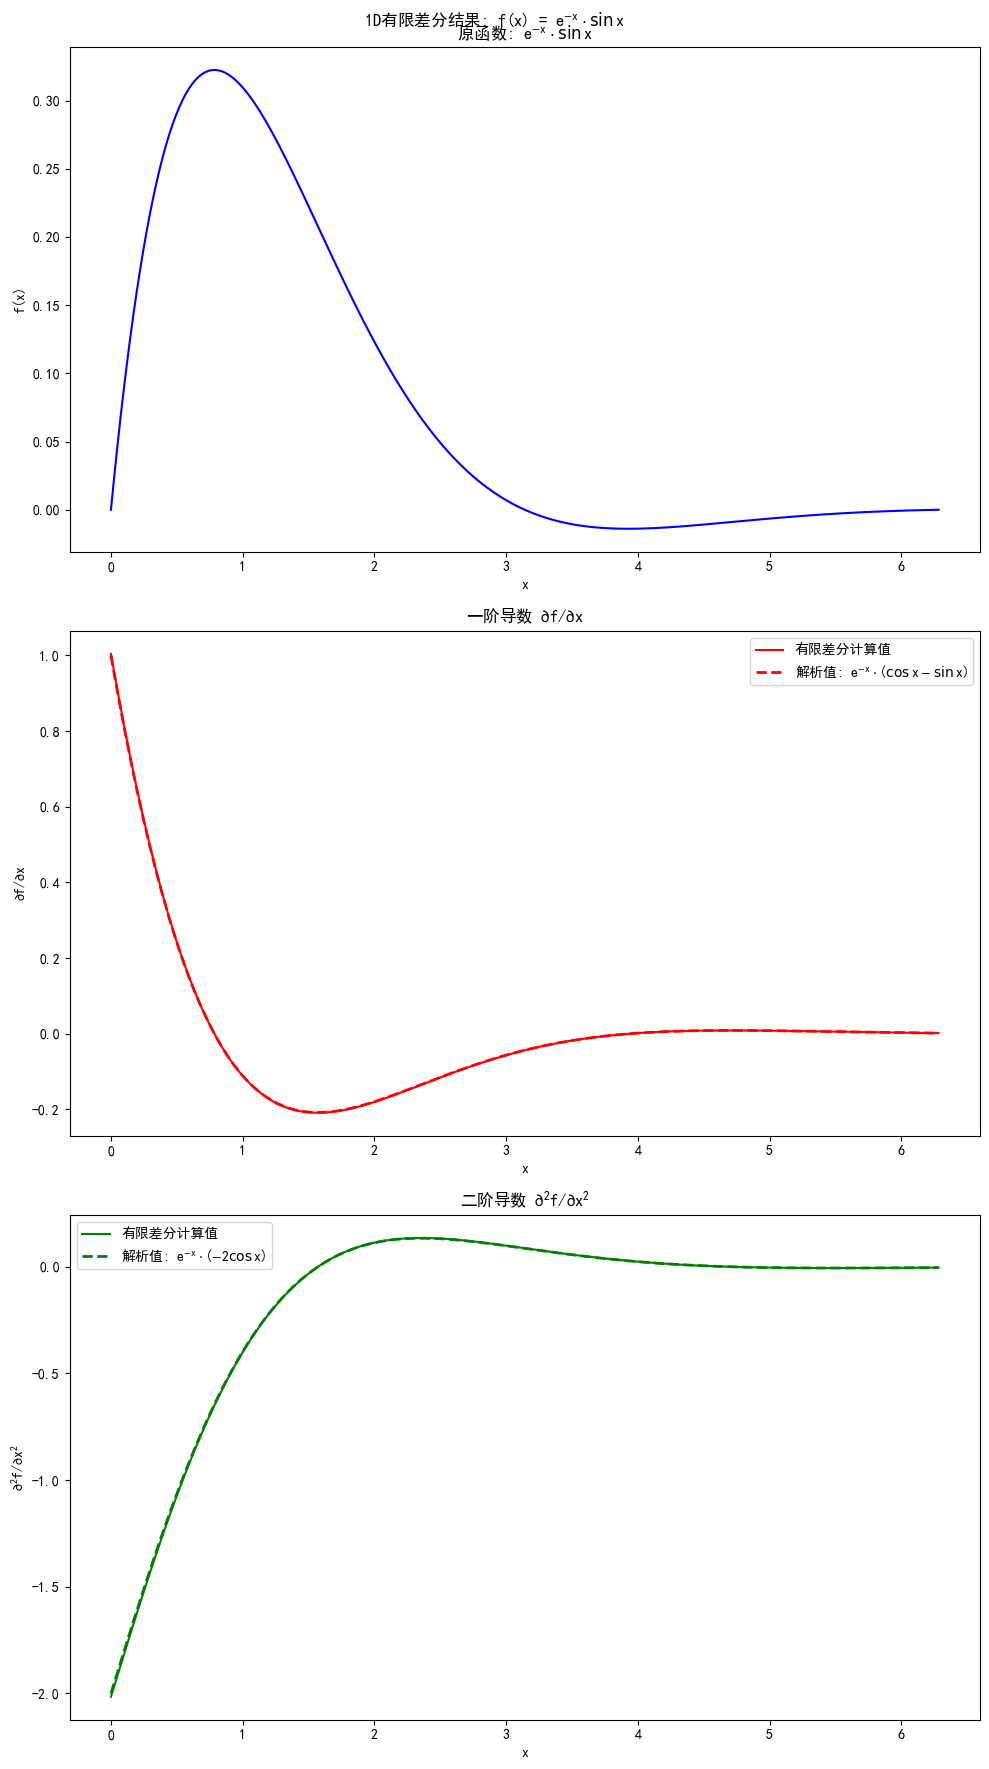

In [96]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
# 创建3行1列的子图，画布大小10×18
fig, axes = plt.subplots(3, 1, figsize=(10, 18))
# 设置总标题
fig.suptitle(r"1D有限差分结果: f(x) = $e^{-x} \cdot \sin x$")

# 绘制原函数
axes[0].plot(x.cpu().numpy(), f_1d.cpu().numpy(), "b-", linewidth=1.5)  # 转numpy并绘图
axes[0].set_title(r"原函数: $e^{-x} \cdot \sin x$")
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")

# 绘制一阶导数
axes[1].plot(x.cpu().numpy(), df_dx.cpu().numpy(), "r-", linewidth=1.5, label="有限差分计算值")
axes[1].plot(x.cpu().numpy(), df_dx_expected.cpu().numpy(), "r--", linewidth=2, label=r"解析值: $e^{-x} \cdot (\cos x - \sin x)$")
axes[1].set_title(r'一阶导数 $\partial f/\partial x$')
axes[1].set_xlabel('x')
axes[1].set_ylabel(r'$\partial f/\partial x$')
axes[1].legend()  # 显示图例

# 绘制二阶导数
axes[2].plot(x.cpu().numpy(), d2f_dx2.cpu().numpy(), "g-", linewidth=1.5, label="有限差分计算值")
axes[2].plot(x.cpu().numpy(), d2f_dx2_expected.cpu().numpy(), "g--", linewidth=2, label=r"解析值: $e^{-x} \cdot (-2\cos x)$")
axes[2].set_title(r"二阶导数 $\partial^2 f/\partial x^2$")
axes[2].set_xlabel("x")
axes[2].set_ylabel(r"$\partial^2 f/\partial x^2$")
axes[2].legend()

# 自动调整子图间距
plt.tight_layout()
# 显示图像
plt.show()


 ---

 # 2. 二维(2D)有限差分示例

 演示FiniteDiff类在二维函数上的使用，包括梯度、散度、旋度、拉普拉斯算子

 ## 构造2D测试函数

 测试函数：$f(x,y) = e^{-x} \cdot \sin(y)$，定义域为 $[0, 2\pi] × [0, 2\pi]$（非周期）

In [97]:
# 定义x和y方向的定义域范围
L_x, L_y = 2 * torch.pi, 2 * torch.pi
# 定义x和y方向的离散点数
nx, ny = 256, 256
# 生成x和y方向的等间距坐标
x = torch.linspace(0, L_x, nx, dtype=torch.float64)
y = torch.linspace(0, L_y, ny, dtype=torch.float64)
# 生成2D网格坐标（indexing="ij"表示矩阵式索引，即(X[i,j], Y[i,j])对应第i行第j列）
X, Y = torch.meshgrid(x, y, indexing="ij")

# 构造2D测试函数 f(x,y) = exp(-x) * sin(y)
f_2d = torch.exp(-X) * torch.sin(Y)


 ## 对2D信号求导

 使用dim=2初始化FiniteDiff类，计算各阶导数、梯度、拉普拉斯算子

In [98]:
# 初始化2D有限差分计算对象
# dim=2：二维数据；h=(hx, hy)：x/y方向的步长；periodic_in_x/y=False：非周期边界
fd2d = FiniteDiff(
    dim=2, h=(L_x / nx, L_y / ny), periodic_in_x=False, periodic_in_y=False
)

# 计算一阶偏导数
df_dx = fd2d.dx(f_2d)  # df/dx
df_dy = fd2d.dy(f_2d)  # df/dy

# 计算二阶偏导数
d2f_dx2 = fd2d.dx(f_2d, order=2)  # d²f/dx²
d2f_dy2 = fd2d.dy(f_2d, order=2)  # d²f/dy²

# 计算拉普拉斯算子 ∇²f = d²f/dx² + d²f/dy²
laplacian = fd2d.laplacian(f_2d)

# 计算解析解（理论值）
df_dx_expected = -torch.exp(-X) * torch.sin(Y)  # df/dx
df_dy_expected = torch.exp(-X) * torch.cos(Y)  # df/dy
d2f_dx2_expected = torch.exp(-X) * torch.sin(Y)  # d²f/dx²
d2f_dy2_expected = -torch.exp(-X) * torch.sin(Y)  # d²f/dy²
laplacian_expected = torch.zeros_like(X)  # ∇²f = 0（二阶偏导相加为0）


 ## 可视化2D结果

 对比原函数、各阶导数、拉普拉斯算子的计算值与解析值

C:\Users\MR\AppData\Local\Temp\ipykernel_10664\3102078375.py:62: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_10664\3102078375.py:62: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()


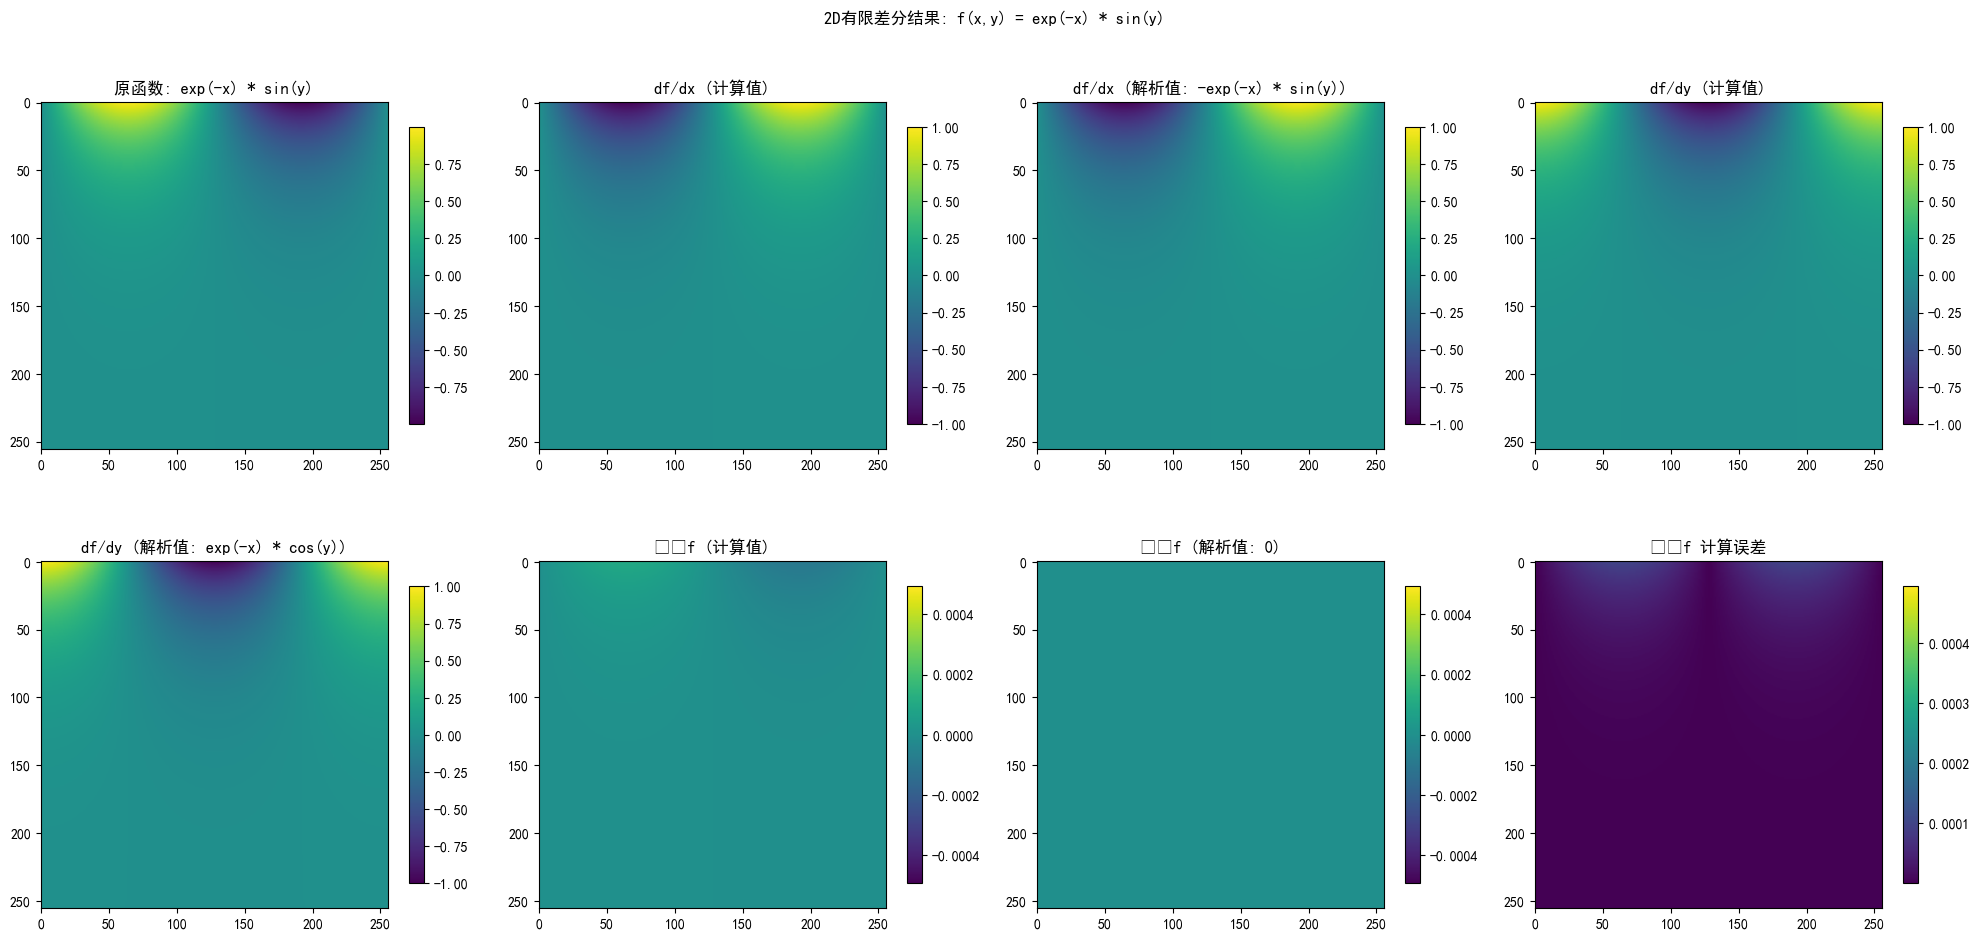

In [99]:
# 创建2行4列的子图，画布大小20×10
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("2D有限差分结果: f(x,y) = exp(-x) * sin(y)")

# 为每个导数对计算统一的色标范围（确保对比时颜色刻度一致）
df_dx_min = min(df_dx.min().item(), df_dx_expected.min().item())
df_dx_max = max(df_dx.max().item(), df_dx_expected.max().item())
df_dy_min = min(df_dy.min().item(), df_dy_expected.min().item())
df_dy_max = max(df_dy.max().item(), df_dy_expected.max().item())

# 二阶导数的色标范围
d2f_dx2_min = min(d2f_dx2.min().item(), d2f_dx2_expected.min().item())
d2f_dx2_max = max(d2f_dx2.max().item(), d2f_dx2_expected.max().item())
d2f_dy2_min = min(d2f_dy2.min().item(), d2f_dy2_expected.min().item())
d2f_dy2_max = max(d2f_dy2.max().item(), d2f_dy2_expected.max().item())

# 拉普拉斯算子的色标范围
laplacian_min = min(laplacian.min().item(), laplacian_expected.min().item())
laplacian_max = max(laplacian.max().item(), laplacian_expected.max().item())

# 绘制原函数
im0 = axes[0, 0].imshow(f_2d.cpu().numpy())  # imshow绘制2D热力图
axes[0, 0].set_title("原函数: exp(-x) * sin(y)")
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)  # 添加色标

# 绘制df/dx计算值
im1 = axes[0, 1].imshow(df_dx.cpu().numpy(), vmin=df_dx_min, vmax=df_dx_max)
axes[0, 1].set_title("df/dx (计算值)")
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# 绘制df/dx解析值
im2 = axes[0, 2].imshow(df_dx_expected.cpu().numpy(), vmin=df_dx_min, vmax=df_dx_max)
axes[0, 2].set_title("df/dx (解析值: -exp(-x) * sin(y))")
plt.colorbar(im2, ax=axes[0, 2], shrink=0.62)

# 绘制df/dy计算值
im3 = axes[0, 3].imshow(df_dy.cpu().numpy(), vmin=df_dy_min, vmax=df_dy_max)
axes[0, 3].set_title("df/dy (计算值)")
plt.colorbar(im3, ax=axes[0, 3], shrink=0.62)

# 绘制df/dy解析值
im4 = axes[1, 0].imshow(df_dy_expected.cpu().numpy(), vmin=df_dy_min, vmax=df_dy_max)
axes[1, 0].set_title("df/dy (解析值: exp(-x) * cos(y))")
plt.colorbar(im4, ax=axes[1, 0], shrink=0.62)

# 绘制拉普拉斯算子计算值
im5 = axes[1, 1].imshow(laplacian.cpu().numpy(), vmin=laplacian_min, vmax=laplacian_max)
axes[1, 1].set_title("∇²f (计算值)")
plt.colorbar(im5, ax=axes[1, 1], shrink=0.62)

# 绘制拉普拉斯算子解析值
im6 = axes[1, 2].imshow(laplacian_expected.cpu().numpy(), vmin=laplacian_min, vmax=laplacian_max)
axes[1, 2].set_title("∇²f (解析值: 0)")
plt.colorbar(im6, ax=axes[1, 2], shrink=0.62)

# 绘制拉普拉斯算子的误差（绝对值）
error = torch.abs(laplacian - laplacian_expected)
im7 = axes[1, 3].imshow(error.cpu().numpy())
axes[1, 3].set_title("∇²f 计算误差")
plt.colorbar(im7, ax=axes[1, 3], shrink=0.62)

plt.tight_layout()
plt.show()


 ## 测试梯度计算

 计算标量场的梯度 ∇f = [df/dx, df/dy]，并验证梯度结果的正确性

C:\Users\MR\AppData\Local\Temp\ipykernel_10664\3183818222.py:28: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) SimHei.
  plt.tight_layout()


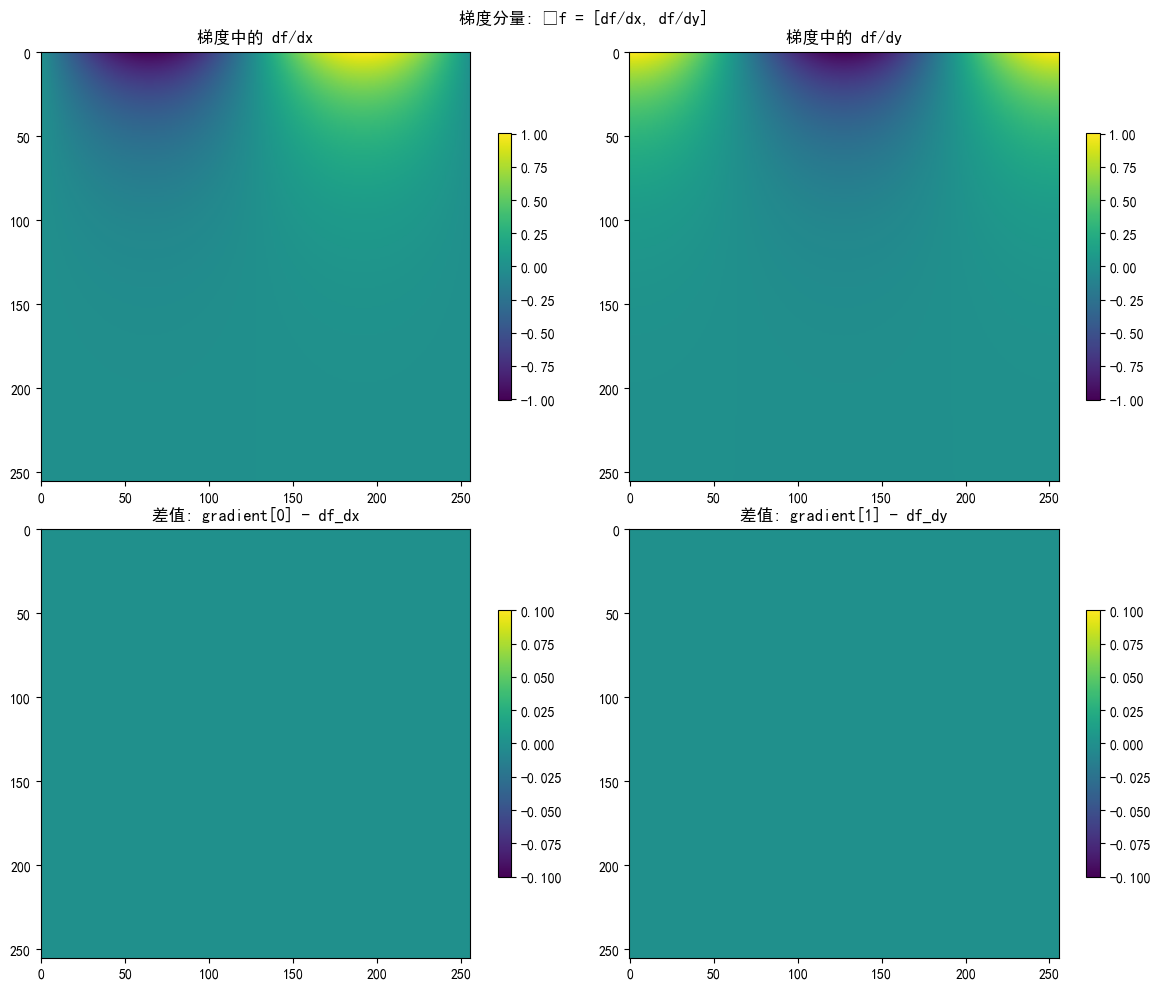

In [100]:
# 计算梯度：返回列表 [df_dx, df_dy]
gradient = fd2d.gradient(f_2d)

# 可视化梯度分量
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("梯度分量: ∇f = [df/dx, df/dy]")

# 绘制梯度中的df/dx
im0 = axes[0, 0].imshow(gradient[0].cpu().numpy(), vmin=df_dx_min, vmax=df_dx_max)
axes[0, 0].set_title("梯度中的 df/dx")
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

# 绘制梯度中的df/dy
im1 = axes[0, 1].imshow(gradient[1].cpu().numpy(), vmin=df_dy_min, vmax=df_dy_max)
axes[0, 1].set_title("梯度中的 df/dy")
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# 对比梯度的df/dx与直接计算的df/dx的差值（验证一致性）
im2 = axes[1, 0].imshow((gradient[0] - df_dx).cpu().numpy())
axes[1, 0].set_title("差值: gradient[0] - df_dx")
plt.colorbar(im2, ax=axes[1, 0], shrink=0.62)

# 对比梯度的df/dy与直接计算的df/dy的差值
im3 = axes[1, 1].imshow((gradient[1] - df_dy).cpu().numpy())
axes[1, 1].set_title("差值: gradient[1] - df_dy")
plt.colorbar(im3, ax=axes[1, 1], shrink=0.62)

plt.tight_layout()
plt.show()


 ## 测试矢量场操作

 构造2D矢量场 $u = [u_1, u_2] = [e^{-x}, \sin(y)]$，计算散度和旋度

In [101]:
# 构造矢量场的两个分量
u1 = torch.exp(-X)  # u₁ = exp(-x)
u2 = torch.sin(Y)   # u₂ = sin(y)
# 堆叠为矢量场（dim=0表示第一个维度为分量维度）
u_vector = torch.stack([u1, u2], dim=0)

# 计算散度 ∇·u = du₁/dx + du₂/dy
divergence = fd2d.divergence(u_vector)
# 计算旋度 ∇×u = du₂/dx - du₁/dy（2D旋度为标量）
curl = fd2d.curl(u_vector)

# 计算解析解
divergence_expected = -torch.exp(-X) + torch.cos(Y)  # ∇·u = -exp(-x) + cos(y)
curl_expected = torch.zeros_like(X)  # ∇×u = 0（u₁与y无关，u₂与x无关）


 ## 可视化矢量场操作结果

 对比散度、旋度的计算值与解析值

C:\Users\MR\AppData\Local\Temp\ipykernel_10664\3698359922.py:48: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_10664\3698359922.py:48: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_10664\3698359922.py:48: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) SimHei.
  plt.tight_layout()


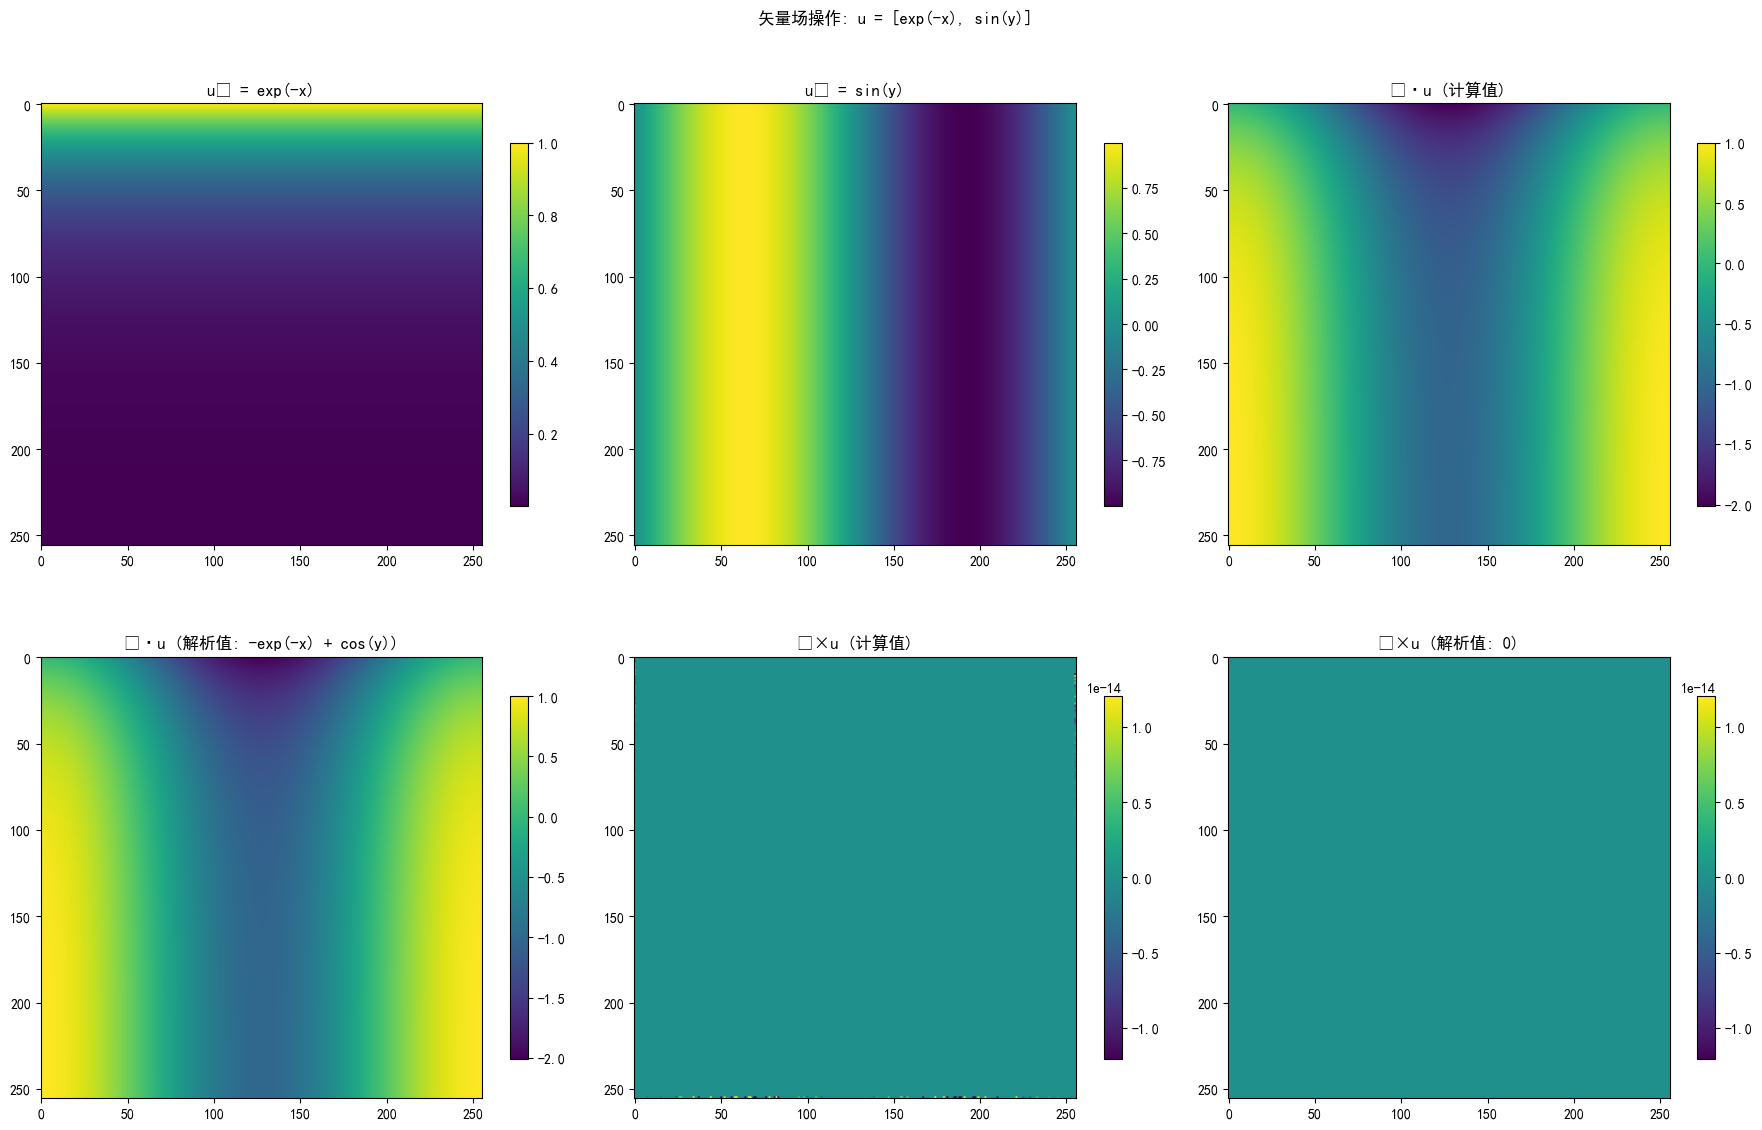

In [102]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("矢量场操作: u = [exp(-x), sin(y)]")

# 计算矢量场分量的色标范围
u1_min = min(u1.min().item(), u1.max().item())
u1_max = max(u1.min().item(), u1.max().item())
u2_min = min(u2.min().item(), u2.max().item())
u2_max = max(u2.min().item(), u2.max().item())

# 散度的色标范围
div_min = min(divergence.min().item(), divergence_expected.min().item())
div_max = max(divergence.max().item(), divergence_expected.max().item())

# 旋度的色标范围
curl_min = min(curl.min().item(), curl_expected.min().item())
curl_max = max(curl.max().item(), curl_expected.max().item())

# 绘制u₁分量
im0 = axes[0, 0].imshow(u1.cpu().numpy(), vmin=u1_min, vmax=u1_max)
axes[0, 0].set_title("u₁ = exp(-x)")
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

# 绘制u₂分量
im1 = axes[0, 1].imshow(u2.cpu().numpy(), vmin=u2_min, vmax=u2_max)
axes[0, 1].set_title("u₂ = sin(y)")
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# 绘制散度计算值
im2 = axes[0, 2].imshow(divergence.cpu().numpy(), vmin=div_min, vmax=div_max)
axes[0, 2].set_title("∇·u (计算值)")
plt.colorbar(im2, ax=axes[0, 2], shrink=0.62)

# 绘制散度解析值
im3 = axes[1, 0].imshow(divergence_expected.cpu().numpy(), vmin=div_min, vmax=div_max)
axes[1, 0].set_title("∇·u (解析值: -exp(-x) + cos(y))")
plt.colorbar(im3, ax=axes[1, 0], shrink=0.62)

# 绘制旋度计算值
im4 = axes[1, 1].imshow(curl.cpu().numpy(), vmin=curl_min, vmax=curl_max)
axes[1, 1].set_title("∇×u (计算值)")
plt.colorbar(im4, ax=axes[1, 1], shrink=0.62)

# 绘制旋度解析值
im5 = axes[1, 2].imshow(curl_expected.cpu().numpy(), vmin=curl_min, vmax=curl_max)
axes[1, 2].set_title("∇×u (解析值: 0)")
plt.colorbar(im5, ax=axes[1, 2], shrink=0.62)

plt.tight_layout()
plt.show()


 ## 补充验证：二阶导数可视化

 单独展示二阶偏导数的计算值与解析值，验证精度

C:\Users\MR\AppData\Local\Temp\ipykernel_10664\2875115297.py:24: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()


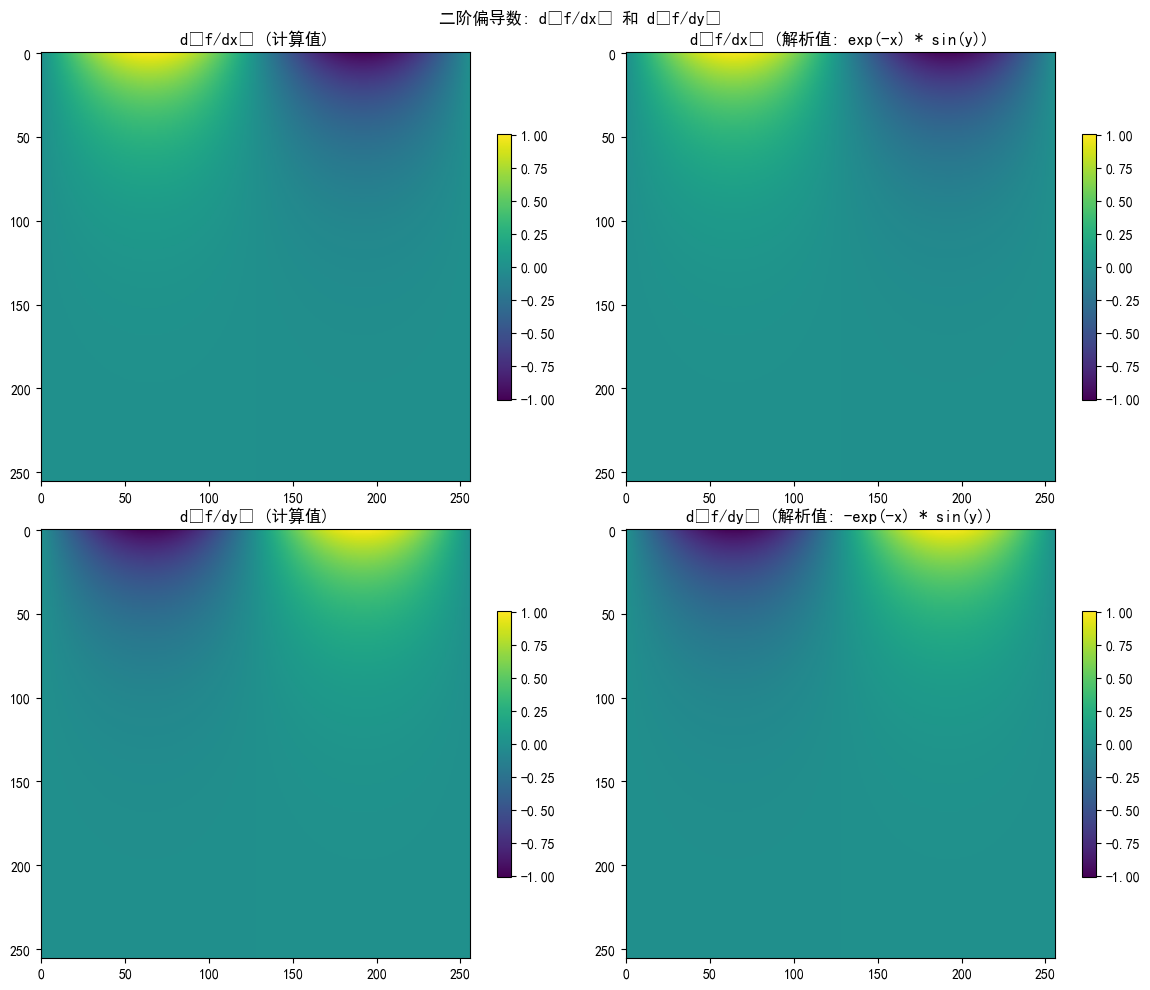

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("二阶偏导数: d²f/dx² 和 d²f/dy²")

# 绘制d²f/dx²计算值
im0 = axes[0, 0].imshow(d2f_dx2.cpu().numpy(), vmin=d2f_dx2_min, vmax=d2f_dx2_max)
axes[0, 0].set_title("d²f/dx² (计算值)")
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

# 绘制d²f/dx²解析值
im1 = axes[0, 1].imshow(d2f_dx2_expected.cpu().numpy(), vmin=d2f_dx2_min, vmax=d2f_dx2_max)
axes[0, 1].set_title("d²f/dx² (解析值: exp(-x) * sin(y))")
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# 绘制d²f/dy²计算值
im2 = axes[1, 0].imshow(d2f_dy2.cpu().numpy(), vmin=d2f_dy2_min, vmax=d2f_dy2_max)
axes[1, 0].set_title("d²f/dy² (计算值)")
plt.colorbar(im2, ax=axes[1, 0], shrink=0.62)

# 绘制d²f/dy²解析值
im3 = axes[1, 1].imshow(d2f_dy2_expected.cpu().numpy(), vmin=d2f_dy2_min, vmax=d2f_dy2_max)
axes[1, 1].set_title("d²f/dy² (解析值: -exp(-x) * sin(y))")
plt.colorbar(im3, ax=axes[1, 1], shrink=0.62)

plt.tight_layout()
plt.show()


 ---

 # 3. 三维(3D)有限差分示例

 演示FiniteDiff类在三维函数上的使用（3D数据无法直接可视化，故展示切片结果）

 ## 构造3D测试函数

 测试函数：$f(x,y,z) = e^{-x} \cdot \sin(y) \cdot \cos(z)$，定义域为 $[0, 2\pi]^3$

In [104]:
# 定义x/y/z方向的定义域范围
L_x, L_y, L_z = 2 * torch.pi, 2 * torch.pi, 2 * torch.pi
# 定义3D离散点数（分辨率低于2D，避免计算量过大）
nx, ny, nz = 80, 84, 76
# 生成x/y/z方向的等间距坐标
x = torch.linspace(0, L_x, nx, dtype=torch.float64)
y = torch.linspace(0, L_y, ny, dtype=torch.float64)
z = torch.linspace(0, L_z, nz, dtype=torch.float64)
# 生成3D网格坐标
X, Y, Z = torch.meshgrid(x, y, z, indexing="ij")

# 构造3D测试函数 f(x,y,z) = exp(-x) * sin(y) * cos(z)
f_3d = torch.exp(-X) * torch.sin(Y) * torch.cos(Z)


 ## 对3D信号求导

 使用dim=3初始化FiniteDiff类，计算各阶偏导数和拉普拉斯算子

In [105]:
# 初始化3D有限差分计算对象
# dim=3：三维数据；h=(hx, hy, hz)：三个方向的步长；
# periodic_in_y/z=True：y/z方向周期边界，x方向非周期
fd3d = FiniteDiff(
    dim=3, h=(L_x / nx, L_y / ny, L_z / nz),
    periodic_in_x=False, periodic_in_y=True, periodic_in_z=True,
)

# 计算一阶偏导数
df_dx = fd3d.dx(f_3d)  # df/dx
df_dy = fd3d.dy(f_3d)  # df/dy
df_dz = fd3d.dz(f_3d)  # df/dz

# 计算二阶偏导数
d2f_dx2 = fd3d.dx(f_3d, order=2)  # d²f/dx²
d2f_dy2 = fd3d.dy(f_3d, order=2)  # d²f/dy²
d2f_dz2 = fd3d.dz(f_3d, order=2)  # d²f/dz²

# 计算3D拉普拉斯算子 ∇²f = d²f/dx² + d²f/dy² + d²f/dz²
laplacian_3d = fd3d.laplacian(f_3d)

# 计算解析解
df_dx_expected = -torch.exp(-X) * torch.sin(Y) * torch.cos(Z)  # df/dx
df_dy_expected = torch.exp(-X) * torch.cos(Y) * torch.cos(Z)   # df/dy
df_dz_expected = -torch.exp(-X) * torch.sin(Y) * torch.sin(Z)  # df/dz

d2f_dx2_expected = torch.exp(-X) * torch.sin(Y) * torch.cos(Z)   # d²f/dx²
d2f_dy2_expected = -torch.exp(-X) * torch.sin(Y) * torch.cos(Z)  # d²f/dy²
d2f_dz2_expected = -torch.exp(-X) * torch.sin(Y) * torch.cos(Z)  # d²f/dz²

# 3D拉普拉斯解析值
laplacian_3d_expected = -torch.exp(-X) * torch.sin(Y) * torch.cos(Z)


 ## 可视化3D结果（z方向中间切片）

 3D数据无法直接可视化，故取z方向中间切片（2D平面）展示结果

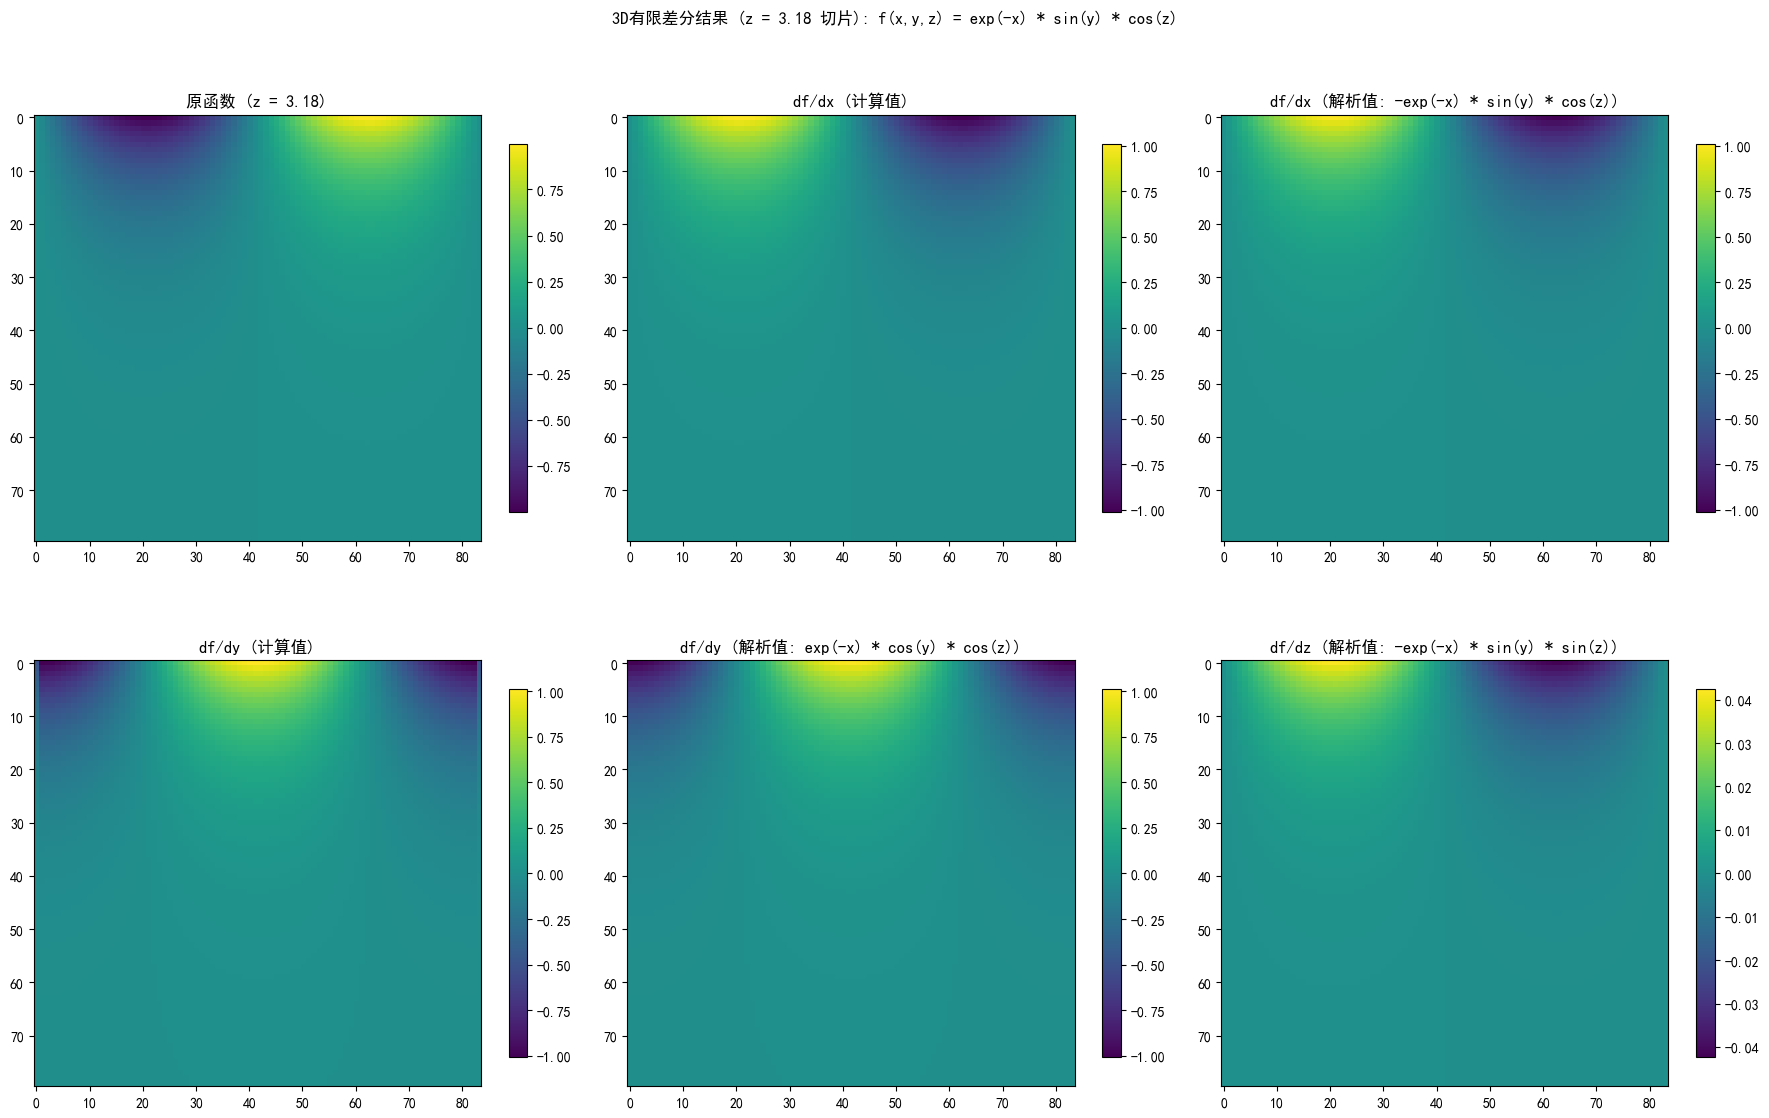

In [106]:
# 选择z方向的中间切片索引
z_slice_idx = nz // 2
# 获取该切片的z坐标值
z_slice_val = z[z_slice_idx].item()

# 创建2行3列的子图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f"3D有限差分结果 (z = {z_slice_val:.2f} 切片): f(x,y,z) = exp(-x) * sin(y) * cos(z)")

# 提取切片数据（仅保留x-y平面）
df_dx_3d_slice = df_dx[:, :, z_slice_idx]
df_dx_expected_3d_slice = df_dx_expected[:, :, z_slice_idx]
df_dy_3d_slice = df_dy[:, :, z_slice_idx]
df_dy_expected_3d_slice = df_dy_expected[:, :, z_slice_idx]
df_dz_3d_slice = df_dz[:, :, z_slice_idx]
df_dz_expected_3d_slice = df_dz_expected[:, :, z_slice_idx]

# 计算切片数据的色标范围
df_dx_3d_min = min(df_dx_3d_slice.min().item(), df_dx_expected_3d_slice.min().item())
df_dx_3d_max = max(df_dx_3d_slice.max().item(), df_dx_expected_3d_slice.max().item())
df_dy_3d_min = min(df_dy_3d_slice.min().item(), df_dy_expected_3d_slice.min().item())
df_dy_3d_max = max(df_dy_3d_slice.max().item(), df_dy_expected_3d_slice.max().item())
df_dz_3d_min = min(df_dz_3d_slice.min().item(), df_dz_expected_3d_slice.min().item())
df_dz_3d_max = max(df_dz_3d_slice.max().item(), df_dz_expected_3d_slice.max().item())

# 绘制原函数切片
im0 = axes[0, 0].imshow(f_3d[:, :, z_slice_idx].cpu().numpy())
axes[0, 0].set_title(f"原函数 (z = {z_slice_val:.2f})")
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

# 绘制df/dx计算值切片
im1 = axes[0, 1].imshow(df_dx_3d_slice.cpu().numpy(), vmin=df_dx_3d_min, vmax=df_dx_3d_max)
axes[0, 1].set_title("df/dx (计算值)")
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# 绘制df/dx解析值切片
im2 = axes[0, 2].imshow(df_dx_expected_3d_slice.cpu().numpy(), vmin=df_dx_3d_min, vmax=df_dx_3d_max)
axes[0, 2].set_title("df/dx (解析值: -exp(-x) * sin(y) * cos(z))")
plt.colorbar(im2, ax=axes[0, 2], shrink=0.62)

# 绘制df/dy计算值切片
im3 = axes[1, 0].imshow(df_dy_3d_slice.cpu().numpy(), vmin=df_dy_3d_min, vmax=df_dy_3d_max)
axes[1, 0].set_title("df/dy (计算值)")
plt.colorbar(im3, ax=axes[1, 0], shrink=0.62)

# 绘制df/dy解析值切片
im4 = axes[1, 1].imshow(df_dy_expected_3d_slice.cpu().numpy(), vmin=df_dy_3d_min, vmax=df_dy_3d_max)
axes[1, 1].set_title("df/dy (解析值: exp(-x) * cos(y) * cos(z))")
plt.colorbar(im4, ax=axes[1, 1], shrink=0.62)

# 绘制df/dz解析值切片
im5 = axes[1, 2].imshow(df_dz_expected_3d_slice.cpu().numpy(), vmin=df_dz_3d_min, vmax=df_dz_3d_max)
axes[1, 2].set_title("df/dz (解析值: -exp(-x) * sin(y) * sin(z))")
plt.colorbar(im5, ax=axes[1, 2], shrink=0.62)

plt.tight_layout()
plt.show()


 ## 测试3D梯度计算

 计算3D标量场的梯度 ∇f = [df/dx, df/dy, df/dz]，并验证结果

C:\Users\MR\AppData\Local\Temp\ipykernel_10664\1792142895.py:38: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) SimHei.
  plt.tight_layout()


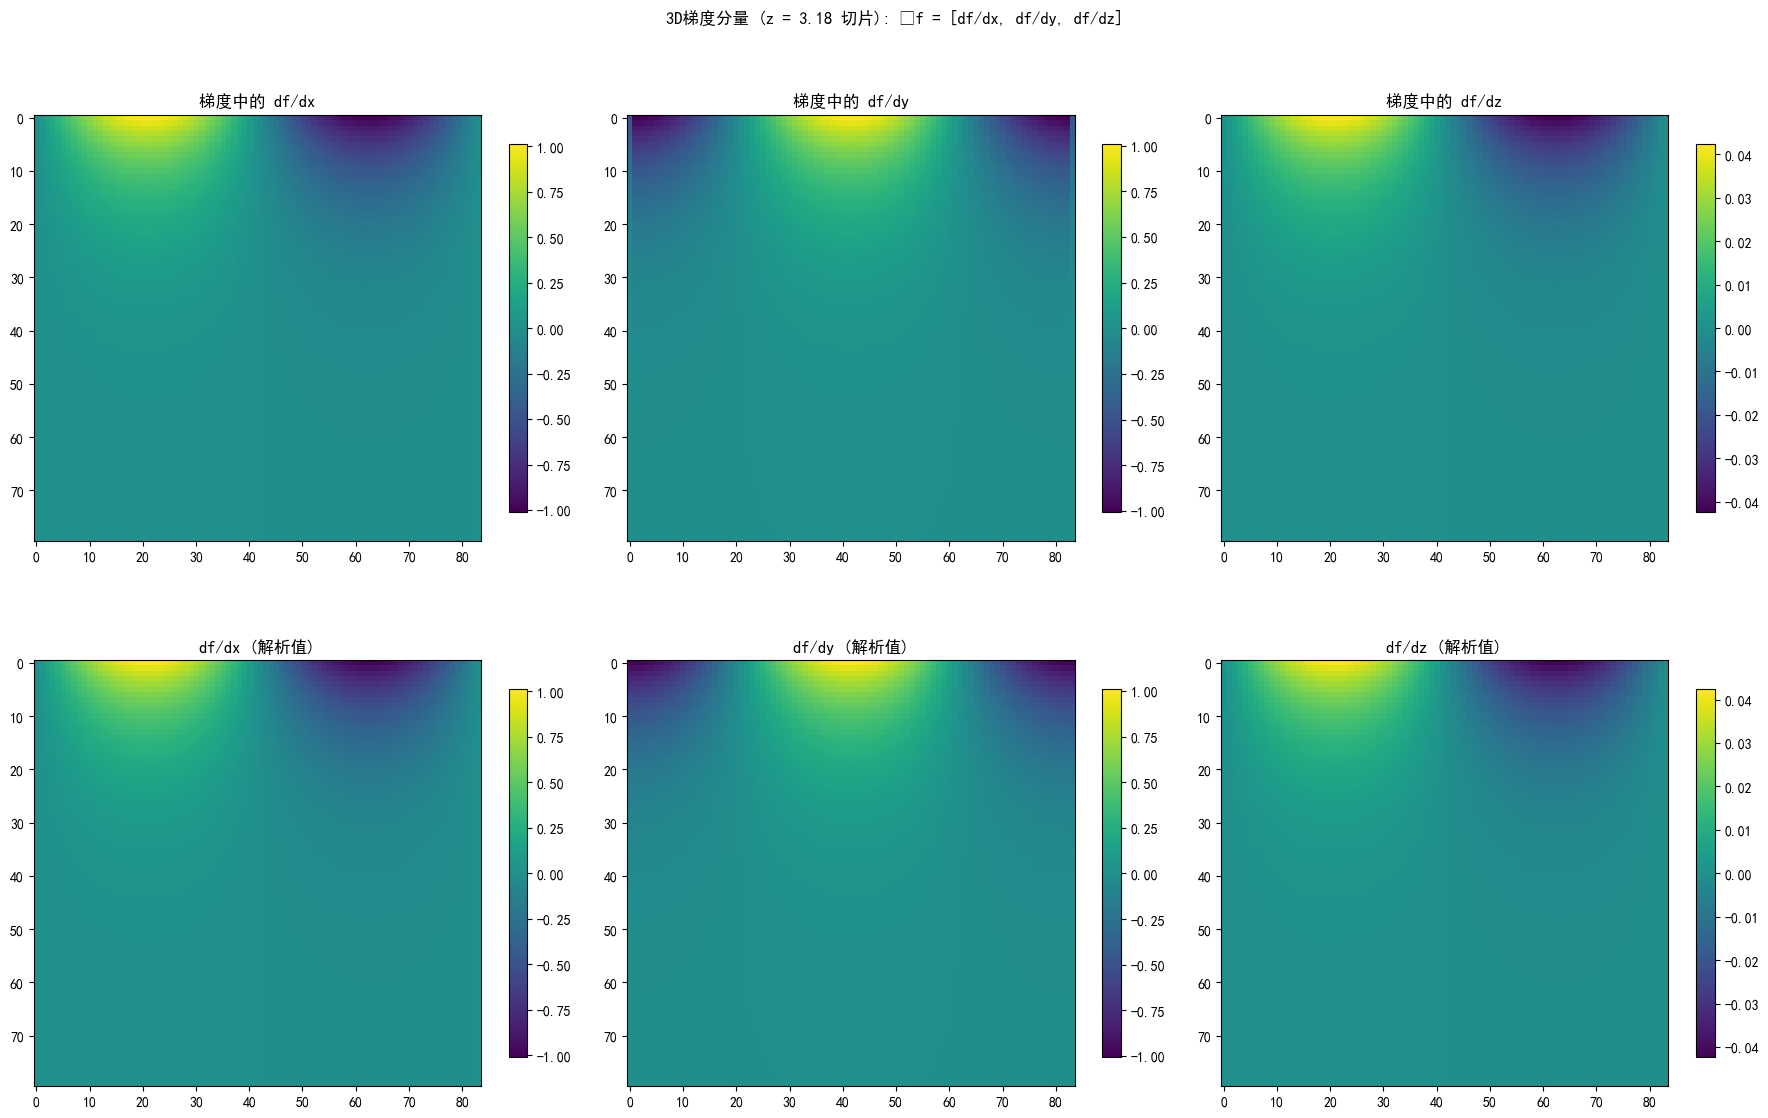

In [107]:
# 计算3D梯度：返回列表 [df_dx, df_dy, df_dz]
gradient_3d = fd3d.gradient(f_3d)

# 可视化梯度分量的z方向切片
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f"3D梯度分量 (z = {z_slice_val:.2f} 切片): ∇f = [df/dx, df/dy, df/dz]")

# 绘制梯度中的df/dx
im0 = axes[0, 0].imshow(gradient_3d[0][:, :, z_slice_idx].cpu().numpy(), vmin=df_dx_3d_min, vmax=df_dx_3d_max)
axes[0, 0].set_title("梯度中的 df/dx")
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

# 绘制梯度中的df/dy
im1 = axes[0, 1].imshow(gradient_3d[1][:, :, z_slice_idx].cpu().numpy(), vmin=df_dy_3d_min, vmax=df_dy_3d_max)
axes[0, 1].set_title("梯度中的 df/dy")
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# 绘制梯度中的df/dz
im2 = axes[0, 2].imshow(gradient_3d[2][:, :, z_slice_idx].cpu().numpy(), vmin=df_dz_3d_min, vmax=df_dz_3d_max)
axes[0, 2].set_title("梯度中的 df/dz")
plt.colorbar(im2, ax=axes[0, 2], shrink=0.62)

# 绘制df/dx解析值
im3 = axes[1, 0].imshow(df_dx_expected_3d_slice.cpu().numpy(), vmin=df_dx_3d_min, vmax=df_dx_3d_max)
axes[1, 0].set_title("df/dx (解析值)")
plt.colorbar(im3, ax=axes[1, 0], shrink=0.62)

# 绘制df/dy解析值
im4 = axes[1, 1].imshow(df_dy_expected_3d_slice.cpu().numpy(), vmin=df_dy_3d_min, vmax=df_dy_3d_max)
axes[1, 1].set_title("df/dy (解析值)")
plt.colorbar(im4, ax=axes[1, 1], shrink=0.62)

# 绘制df/dz解析值
im5 = axes[1, 2].imshow(df_dz_expected_3d_slice.cpu().numpy(), vmin=df_dz_3d_min, vmax=df_dz_3d_max)
axes[1, 2].set_title("df/dz (解析值)")
plt.colorbar(im5, ax=axes[1, 2], shrink=0.62)

plt.tight_layout()
plt.show()


 ## 测试3D矢量场操作

 构造3D矢量场 $u = [u_1, u_2, u_3] = [e^{-x}, \sin(y), \cos(z)]$，计算散度

In [108]:
# 构造3D矢量场的三个分量
u1_3d = torch.exp(-X)    # u₁ = exp(-x)
u2_3d = torch.sin(Y)     # u₂ = sin(y)
u3_3d = torch.cos(Z)     # u₃ = cos(z)
# 堆叠为3D矢量场（dim=0为分量维度）
u_vector_3d = torch.stack([u1_3d, u2_3d, u3_3d], dim=0)

# 计算3D散度 ∇·u = du₁/dx + du₂/dy + du₃/dz
divergence_3d = fd3d.divergence(u_vector_3d)

# 计算散度解析值
divergence_3d_expected = -torch.exp(-X) + torch.cos(Y) - torch.sin(Z)


 ## 可视化3D矢量场操作结果（z方向切片）

C:\Users\MR\AppData\Local\Temp\ipykernel_10664\660005781.py:49: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_10664\660005781.py:49: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_10664\660005781.py:49: UserWarning: Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_10664\660005781.py:49: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) SimHei.
  plt.tight_layout()


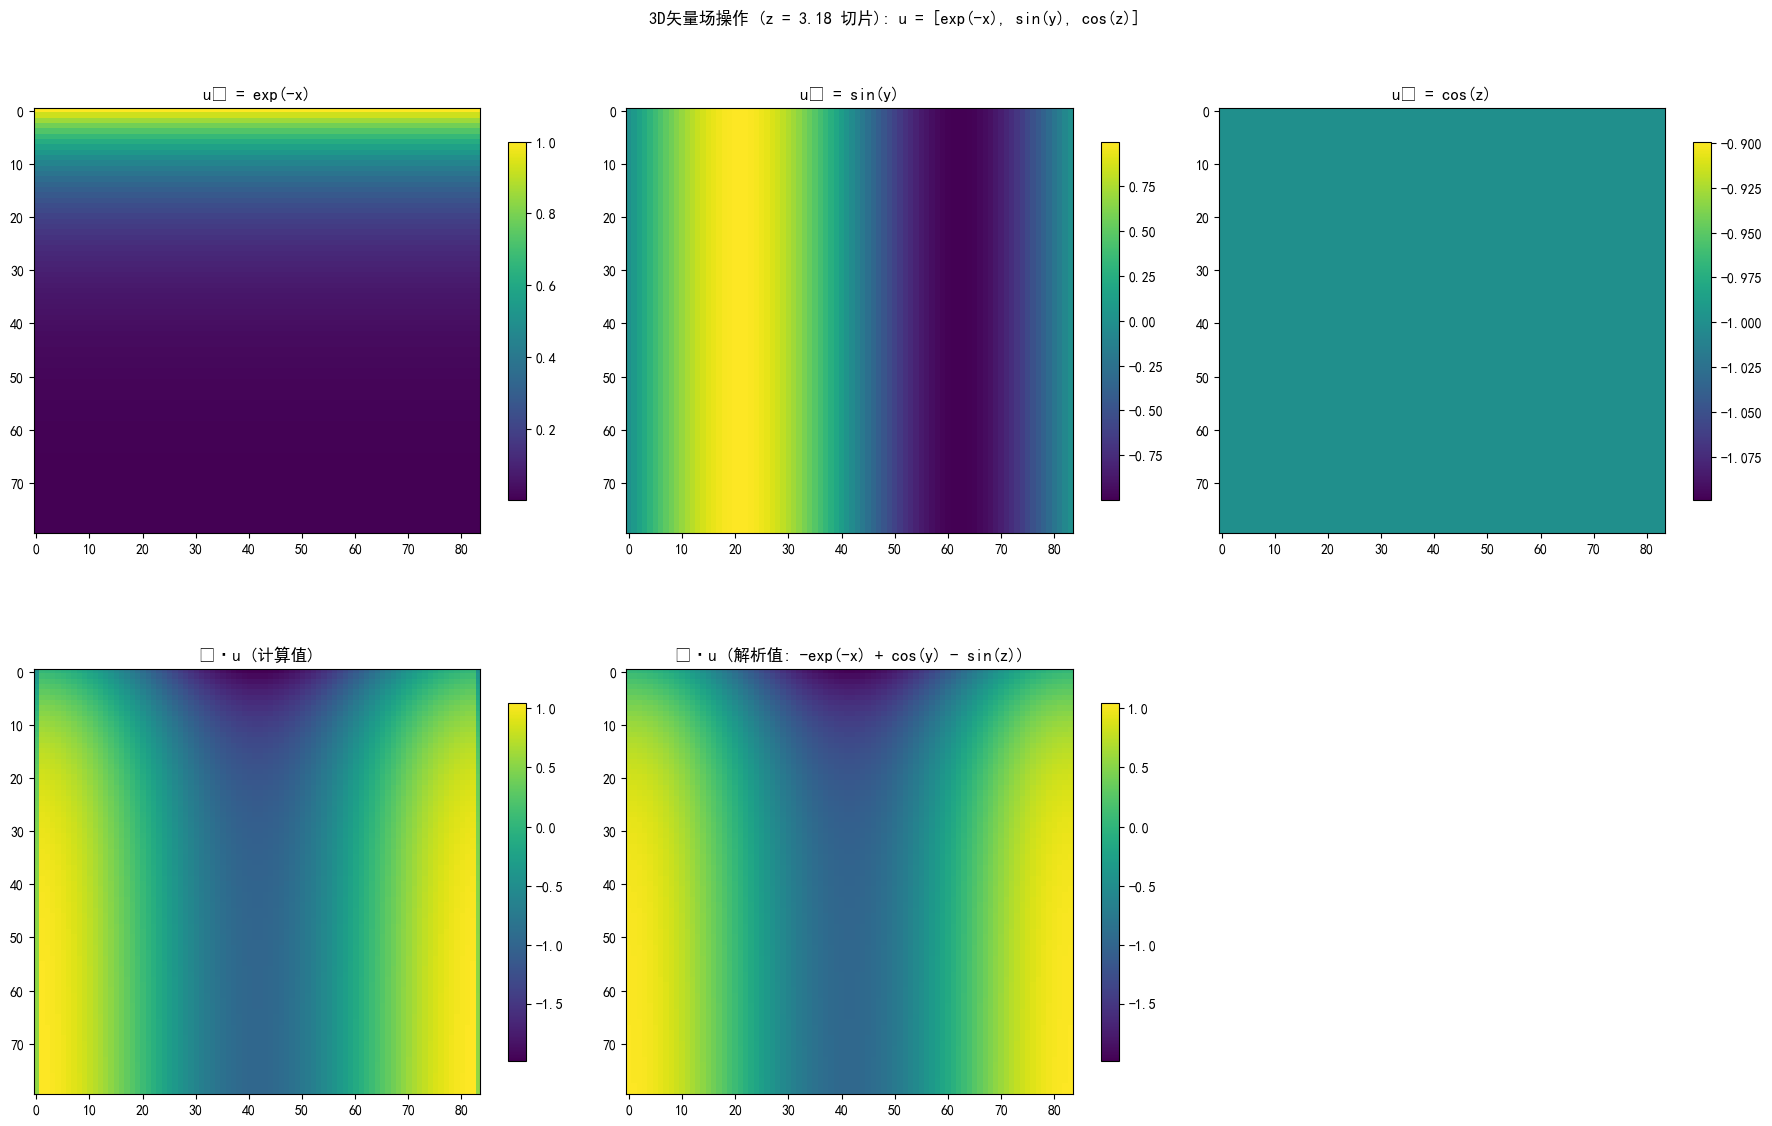

In [109]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f"3D矢量场操作 (z = {z_slice_val:.2f} 切片): u = [exp(-x), sin(y), cos(z)]")

# 提取切片数据
u1_3d_slice = u1_3d[:, :, z_slice_idx]
u2_3d_slice = u2_3d[:, :, z_slice_idx]
u3_3d_slice = u3_3d[:, :, z_slice_idx]
div_3d_slice = divergence_3d[:, :, z_slice_idx]
div_3d_expected_slice = divergence_3d_expected[:, :, z_slice_idx]

# 计算色标范围
u1_3d_min = min(u1_3d_slice.min().item(), u1_3d_slice.max().item())
u1_3d_max = max(u1_3d_slice.min().item(), u1_3d_slice.max().item())
u2_3d_min = min(u2_3d_slice.min().item(), u2_3d_slice.max().item())
u2_3d_max = max(u2_3d_slice.min().item(), u2_3d_slice.max().item())
u3_3d_min = min(u3_3d_slice.min().item(), u3_3d_slice.max().item())
u3_3d_max = max(u3_3d_slice.min().item(), u3_3d_slice.max().item())
div_3d_min = min(div_3d_slice.min().item(), div_3d_expected_slice.min().item())
div_3d_max = max(div_3d_slice.max().item(), div_3d_expected_slice.max().item())

# 绘制u₁分量切片
im0 = axes[0, 0].imshow(u1_3d_slice.cpu().numpy(), vmin=u1_3d_min, vmax=u1_3d_max)
axes[0, 0].set_title("u₁ = exp(-x)")
plt.colorbar(im0, ax=axes[0, 0], shrink=0.62)

# 绘制u₂分量切片
im1 = axes[0, 1].imshow(u2_3d_slice.cpu().numpy(), vmin=u2_3d_min, vmax=u2_3d_max)
axes[0, 1].set_title("u₂ = sin(y)")
plt.colorbar(im1, ax=axes[0, 1], shrink=0.62)

# 绘制u₃分量切片
im2 = axes[0, 2].imshow(u3_3d_slice.cpu().numpy(), vmin=u3_3d_min, vmax=u3_3d_max)
axes[0, 2].set_title("u₃ = cos(z)")
plt.colorbar(im2, ax=axes[0, 2], shrink=0.62)

# 绘制散度计算值切片
im3 = axes[1, 0].imshow(div_3d_slice.cpu().numpy(), vmin=div_3d_min, vmax=div_3d_max)
axes[1, 0].set_title("∇·u (计算值)")
plt.colorbar(im3, ax=axes[1, 0], shrink=0.62)

# 绘制散度解析值切片
im4 = axes[1, 1].imshow(div_3d_expected_slice.cpu().numpy(), vmin=div_3d_min, vmax=div_3d_max)
axes[1, 1].set_title("∇·u (解析值: -exp(-x) + cos(y) - sin(z))")
plt.colorbar(im4, ax=axes[1, 1], shrink=0.62)

# 隐藏最后一个子图（保持对称）
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()